#  Randomized Principal Component Analysis (rPCA)
************************************************************************************
The essential idea of PCA is to find a new set of uncorrelated variables
that retain most of the information present in the data. Let $\mathbf{X}$ be a scaled (mean centered/ standardized) matrix of dimension $m\times n$. The aim of PCA is to find a factorization in form of

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{X}  & \approx & \mathbf{Z} & \mathbf{W}^\top\\
	m\times n &   &  m\times k  & k\times n
	\end{array} 
\end{equation}

$\mathbf{Z}$ denotes the principal components, and $\mathbf{W}$ denotes the principal directions (eigenvectors).

To demonstrate the randomized PCA we use handwritten digits. We shows how to extract key features from high-dimensional data, which is a classic example for dimension reduction. 

### Get Started

We start by loading the standard libraries:

In [2]:
import numpy as np
import scipy as sci
from scipy import ndimage 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white")

### The Dataset

Next, we load and visualize the first 25 hand-written digits in the dataset:

In [3]:
# Load data
digits = np.load('../data/digits.npz')
target = digits['target']
images = digits['images']

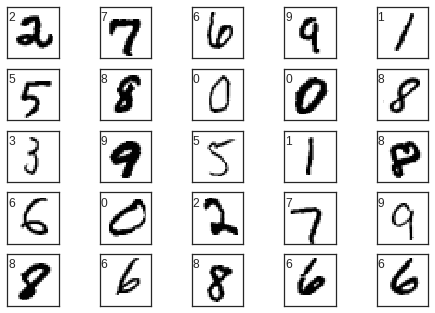

In [4]:
# set up the figure
fig, ax = plt.subplots(5,5)

# plot the digits: each image is 28x28 pixels
index = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[index,:].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')
        ax[i,j].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

        # label the image with the target value
        ax[i,j].text(0, 7, str(int(target[index])))
        index +=1
plt.show()

The data consists of 28×28 pixel images, meaning that they are 784-dimensional. Note, that this dataset is only a small subset of the MNIST database: http://yann.lecun.com/exdb/mnist/index.html.

# Compute Randomized Principal Components

To gain some intuition into the relationships between these points, we can use randomized PCA to project them to low-dimensional space, say into a 2-dimensional space:

In [5]:
k=2

In the following we compute the randomized principal components via the randomized SVD. The first step requires us to mean center the data:

In [6]:
digits_mean = np.mean(images, axis=0)

If you like, you can display the mean image:

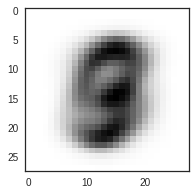

In [7]:
# plot the mean image
fig = plt.figure(figsize=(3, 3))
plt.imshow(digits_mean.reshape(28,28))
plt.show()

To compute the principal components of the covariance matrix via the SVD we need to center the data:

In [8]:
images_centered = images - digits_mean

Now, we can simply use the rsvd routine from the ristretto library to compute the principal directions (eigenvectors/ right singular vectors) $\mathbf{W}:=\mathbf{V}$:

In [9]:
from ristretto.mf import rsvd
k=100
U, s, Wt = rsvd(images_centered, k=k)  # project from 784 to 2 dimensions
Wt.shape

(100, 784)

In [10]:
Z = images_centered.dot(Wt.T)
Z.shape

(5000, 100)

Note that we have the following relationship between the principal components and the left singular vectors
\begin{equation}
\mathbf{Z} = \mathbf{XW} = \mathbf{U \Sigma V}^\top \mathbf{W} = \mathbf{U \Sigma}. 
\end{equation}
Thus, in practice you can compute the principal components as:

In [11]:
#Z = U * s
#Z.shape

We can now plot the first two principal components of each point to learn about the data. To improve the interpretability, we just plot the first 1000 data points:

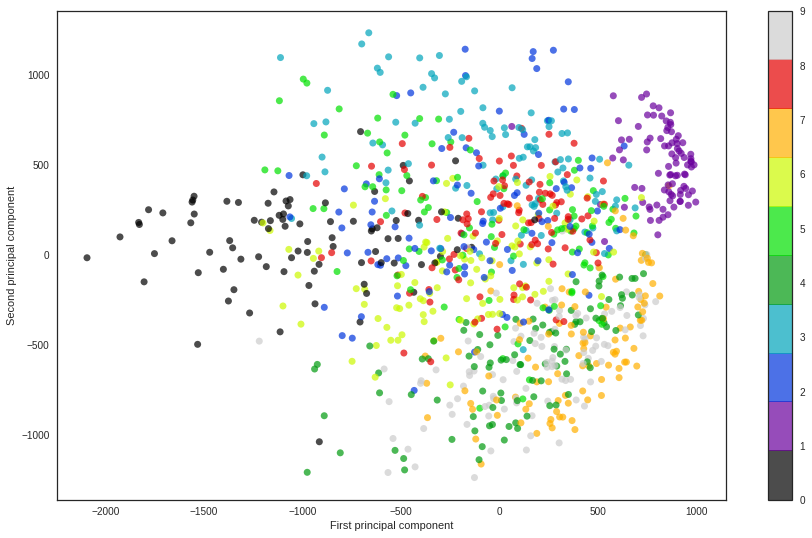

In [16]:
# Set up the figure
fig = plt.figure(figsize=(15, 9))

# Display the first 1000 data points in two dimensions
plt.scatter(Z[0:1000,0], Z[0:1000,1], c=target[0:1000], edgecolor='none', alpha=0.7, 
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar()
plt.show()

How much of the total variance is explained by the principal components? We need first to compute appropriately scale the singular values:

In [17]:
n_samles = Z.shape[0]
eigenvals = 1./(n_samles-1) * s**2

The eigenvalues are a measure for the explained variance. 

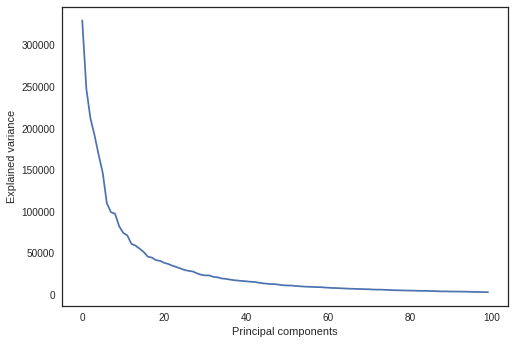

In [18]:
plt.plot(eigenvals)
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.show()

Now, we can plot the cumulative explained variance ratio:

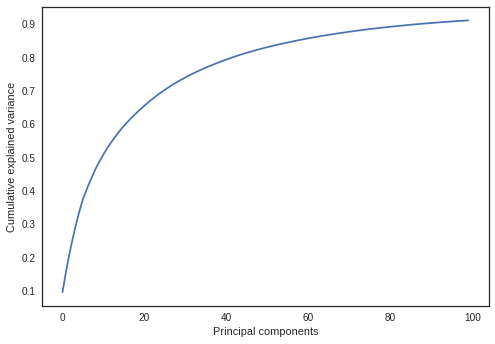

In [19]:
total_variance = np.sum(np.var(images_centered,axis=0))
explained_variance_ratio = eigenvals / total_variance

plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.show()

So the first two principal components account for about 

In [20]:
np.cumsum(explained_variance_ratio)[1]

0.16717293600293323

of the total variance in the data.

You can also plot the basis functions:

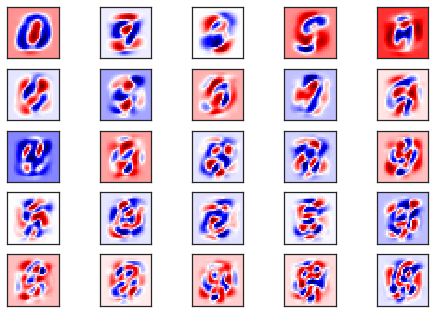

In [21]:
# set up the figure
fig, ax = plt.subplots(5,5)

# plot the digits: each image is 28x28 pixels
index = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(Wt[index,:].reshape(28,28), cmap=plt.cm.seismic, interpolation='nearest')
        ax[i,j].tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
        index +=1
plt.show()

# Handwritten Digit Classification

In the following we build a simple handwritten digit classifier using both random forest and k-nearest neighbors. 

To evaluate the classification performance later, we split the dataset into a trainings and test set:

In [22]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(images, target, random_state=0)

Again, we mean center the training data first:

In [23]:
Xtrain_mean = np.mean(Xtrain, axis=0)
Xtrain_centered = Xtrain - Xtrain_mean

Then, we compute the $k=40$ dominant principal components $\mathbf{Z}$ using the randomized SVD:

In [24]:
U, s, Wt = rsvd(Xtrain_centered, k=40)  # project from 784 to 2 dimensions
Z = U * s

### Random forest

First we use the random forest technique (https://en.wikipedia.org/wiki/Random_forest) for classification. Specifically, we use the algorithm implemented in the scikit-learn package (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with its default settings:

In [25]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=500)
model_RF.fit(Z, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Next, we use the model to predict the classes of the test samples:

In [27]:
# Substract mean from test set
Xtest_centered = Xtest - Xtrain_mean

# Project mean centered test set to low-dimensional space
Z_test = Xtest_centered.dot(Wt.T)

# predict classes
ypred = model_RF.predict(Z_test)

To contextualize the classification performance, the sklearn metrics function can be used:

In [28]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

        0.0       0.95      0.92      0.93       120
        1.0       0.97      0.95      0.96       117
        2.0       0.88      0.89      0.89       123
        3.0       0.91      0.92      0.92       115
        4.0       0.94      0.92      0.93       128
        5.0       0.89      0.87      0.88       133
        6.0       0.96      0.93      0.95       135
        7.0       0.86      0.92      0.89       113
        8.0       0.84      0.91      0.88       129
        9.0       0.88      0.84      0.86       137

avg / total       0.91      0.91      0.91      1250



We yield an F-score of about 0.92 using just the dominant $k=40$ principal components.

### k-nearest neighbors

Next, we use k-nearest neighbors (https://it.wikipedia.org/wiki/K-nearest_neighbors) for classification. Again, we use the algorithm provided by the sklearn library (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and we chose n_neighbors=5:

In [32]:
from sklearn.neighbors import KNeighborsClassifier
model_neigh = KNeighborsClassifier(n_neighbors=5)
model_neigh.fit(Z, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

We predict the class labels using this model as follows: 

In [33]:
ypred = model_neigh.predict(Z_test)

And here is the performance of k-nearest neighbors technique:  

In [34]:
print(metrics.classification_report(ypred, ytest))

             precision    recall  f1-score   support

        0.0       0.99      0.91      0.95       126
        1.0       0.99      0.97      0.98       118
        2.0       0.92      0.98      0.95       117
        3.0       0.93      0.94      0.94       115
        4.0       0.92      0.91      0.92       127
        5.0       0.94      0.91      0.92       134
        6.0       0.95      0.93      0.94       134
        7.0       0.92      0.90      0.91       123
        8.0       0.84      0.96      0.90       123
        9.0       0.89      0.87      0.88       133

avg / total       0.93      0.93      0.93      1250



Interestingly, k-nearest neighbors performs slightly better than the more complex random forest model. However, the performance of the random forest model can be improved by adjusting the tuning parameters, or using the full data instead of the principal components. The point here is to demonstrate that the randomized principal components perform as good (or even better) than the principal components computed via a deterministic algorithm. If you do not believe that, re-compute the above example using the deterministic SVD and compare the results. 

# Acknowledgements
**********************************
More details about the handwritten digit database, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a Creative Commons Attribution-Share Alike 3.0 license.